In [1]:
import pydicom
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2 as cv
from PIL import Image
import xml.etree.ElementTree as ET

## ①项目目录下创建VOC数据集的几个文件夹
VOCdevkit/VOC2012/Annotation<br>
VOCdevkit/VOC2012/ImageSets/Main<br>
VOCdevkit/VOC2012/JPEGImages

## ②读取dcm文件与xml文件的配对表
在上一节已经创建这一配对表，直接读取csv文件

In [2]:
xml_file_dataset = pd.read_csv('xml_file_dataset.csv', index_col=0)
xml_file_dataset

,xml,uid_str,dcm
0,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.102500633407...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...
1,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.103293611003...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...
2,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.136943255924...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...
3,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.155870813347...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...
4,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.184131899543...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...
...,...,...,...
30879,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.922096117047...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...
30880,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.923461426394...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...
30881,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.968393286572...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...
30882,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.985887477459...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...


添加新列，赋予它们新的名字：编号从 000000~999999。

In [3]:
xml_file_dataset['filename'] = xml_file_dataset.index.values
xml_file_dataset['filename'] = xml_file_dataset['filename'].astype(str)
xml_file_dataset['filename'] = xml_file_dataset['filename'].str.zfill(6)
xml_file_dataset

,xml,uid_str,dcm,filename
0,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.102500633407...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...,000000
1,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.103293611003...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...,000001
2,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.136943255924...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...,000002
3,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.155870813347...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...,000003
4,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.184131899543...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...,000004
...,...,...,...,...
30879,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.922096117047...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...,030879
30880,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.923461426394...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...,030880
30881,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.968393286572...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...,030881
30882,Lung-PET-CT-Dx-Annotations-XML-Files-rev122220...,1.3.6.1.4.1.14519.5.2.1.6655.2359.985887477459...,manifest-1608669183333/Lung-PET-CT-Dx\Lung_Dx-...,030882


## ③创建VOC格式数据集

思路：<br>
1. 将xml列的xml文件中的[filename]标签写入“filename列对应名称.jpg”（如：000000.jpg），并命名为“ filename列对应名称.xml” （如：000000.xml）保存到 VOCdevkit/VOC2012/Annotations 文件夹下。<br>
2. 将dcm列的dcm文件另存为 “filename列对应名称.jpg”（如：000000.jpg），存到 VOCdevkit/VOC2012/JPEGImages文件夹下。

In [4]:
xml_list = xml_file_dataset['xml'].values
dcm_list = xml_file_dataset['dcm'].values
filename_list = xml_file_dataset['filename'].values

# 将xml文件中的[filename]标签写入“filename列对应名称.jpg”（如：000000.jpg），并命名为“ filename列对应名称.xml” （如：000000.xml）保存到 VOCdevkit/VOC2012/Annotations 文件夹下。
def to_switch_xml(xml, filename):
    tree = ET.parse(xml)
    root = tree.getroot()
    sub1 = root.find('filename')
    sub1.text = filename + '.jpg'
    tree.write('./VOCdevkit/VOC2012/Annotations/{}.xml'.format(filename))

# 将dcm文件另存为 “filename列对应名称.jpg”（如：000000.jpg），存到 VOCdevkit/VOC2012/JPEGImages文件夹下。
def to_switch_dcm(dcm, filename):
    img_open=pydicom.read_file(dcm)
    img_array=img_open.pixel_array

    # 将PETCT的三通道格式转成单通道格式
    if len(img_array.shape) == 3:
        img_array = cv.cvtColor(img_array, cv.COLOR_BGR2GRAY)

    img_array = np.array(img_array, dtype=np.float32)
    img = Image.fromarray(img_array)
    img = img.convert('L')
    # quality参数： 保存图像的质量，值的范围从1（最差）到95（最佳）。 默认值为75，使用中应尽量避免高于95的值; 100会禁用部分JPEG压缩算法，并导致大文件图像质量几乎没有任何增益。
    img.save('./VOCdevkit/VOC2012/JPEGImages/{}.jpg'.format(filename), quality=95)
    img.close()

In [5]:
# 测试一下
# to_switch_xml(xml_list[0], filename_list[0])
# to_switch_dcm(dcm_list[0], filename_list[0])

In [6]:
# 在SSD上预计需要跑2分钟
for xml, filename in tqdm(zip(xml_list, filename_list), total=len(xml_list)):
    to_switch_xml(xml, filename)

100%|██████████| 30884/30884 [01:49<00:00, 280.92it/s]


In [7]:
# 在SSD上预计需要跑10分钟
for dcm, filename in tqdm(zip(dcm_list, filename_list), total=len(dcm_list)):
    to_switch_dcm(dcm, filename)

100%|██████████| 30884/30884 [09:37<00:00, 53.46it/s]


测试一下

In [19]:
# 设计一个函数，传入xml文件路径，显示图片和锚框
##################

# 从XML文件获取bounding box信息
def get_labelFromXml(xml_file):     
    label=[]
    bbox_list=[]

    an_file = open(xml_file, encoding='utf-8')
    tree=ET.parse(an_file)
    root = tree.getroot()
    for object in root.findall('object'):    
        cancer_type=object.find('name').text.upper()
        xmin=object.find('bndbox').find('xmin').text
        xmax=object.find('bndbox').find('xmax').text
        ymin=object.find('bndbox').find('ymin').text
        ymax=object.find('bndbox').find('ymax').text

        if int(xmin)==0 or int(xmax)==0 or int(ymin)==0 or int(ymax)==0:
            pass
        elif int(xmin)==int(xmax) or int(ymin)==int(ymax):
            pass
        else:
            bbox=[int(xmin),int(ymin),int(xmax),int(ymax)]
            bbox_list.append(bbox)
            label.append(cancer_type)
    return bbox_list,label

# 画布上添加锚框
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

def show_img_and_anchors(filename):  # 传入文件名（000000~030883），展示标注效果，一张图片可显示多个bbox框
    # 获取
    url = './VOCdevkit/VOC2012/JPEGImages/{}.jpg'.format(filename)
    img_arr = Image.open(url)

    plt.figure(figsize=(9, 9))
    fig = plt.imshow(img_arr,cmap=plt.cm.bone)
    plt.title("filename:{}".format(filename))

    url = './VOCdevkit/VOC2012/Annotations/{}.xml'.format(filename)
    bbox, label = get_labelFromXml(url)

    for i, j in zip(bbox, label):
        fig.axes.add_patch(bbox_to_rect(i, 'red'))
        fig.axes.text(i[0]+12, i[1]+12, j,
                            va='center', ha='center', fontsize=12, color='red')

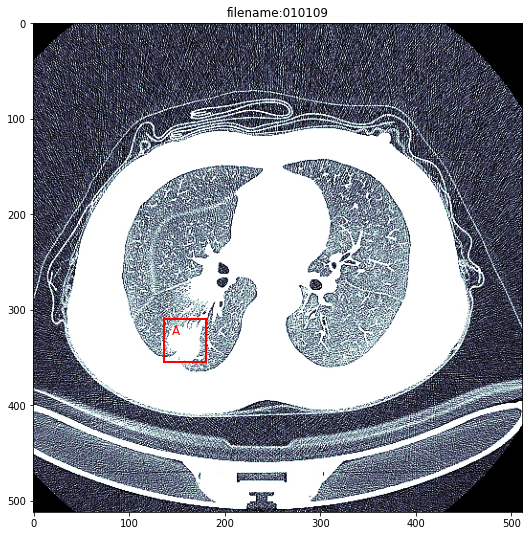

In [76]:
import random
num = random.randint(0, len(dcm_list)-1)
num = str(num).zfill(6)
show_img_and_anchors(num)

## ④创建训练、验证集
ImageSets/Main文件夹下创建 train.txt、val.txt

In [79]:
import os
import random

random.seed(0)  # 设置随机种子，保证随机结果可复现

files_path = "./VOCdevkit/VOC2012/Annotations"
assert os.path.exists(files_path), "path: '{}' does not exist.".format(files_path)

val_rate = 0.3  # 设置多少归为验证集

files_name = sorted([file.split(".")[0] for file in os.listdir(files_path)])
files_num = len(files_name)
val_index = random.sample(range(0, files_num), k=int(files_num*val_rate))
train_files = []
val_files = []
for index, file_name in enumerate(files_name):
    if index in val_index:
        val_files.append(file_name)
    else:
        train_files.append(file_name)

try:
    train_f = open("./VOCdevkit/VOC2012/ImageSets/Main/train.txt", "x")
    eval_f = open("./VOCdevkit/VOC2012/ImageSets/Main/val.txt", "x")
    train_f.write("\n".join(train_files))
    eval_f.write("\n".join(val_files))
except FileExistsError as e:
    print(e)
    exit(1)